In [1]:
!nvidia-smi


Mon May 19 10:25:10 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.25       Driver Version: 516.25       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000   WDDM  | 00000000:65:00.0  On |                  Off |
| 41%   45C    P8    10W / 140W |    842MiB / 16376MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import os
import glob

In [3]:
os.chdir("gait-in-neurodegenerative-disease-database-1.0.0")

In [4]:
subject_info = pd.read_csv("subject-description.txt", sep="\t")
subject_info.head()

,Unnamed: 0,GROUP,AGE(YRS),HEIGHT(meters),Weight(kg),gender,GaitSpeed(m/sec),Duration/Severity
0,control1,control,57.0,1.94,95,f,1.33,0.0
1,control2,control,22.0,1.94,70,m,1.47,0.0
2,control3,control,23.0,1.83,66,f,1.44,0.0
3,control4,control,52.0,1.78,73,f,1.54,0.0
4,control5,control,47.0,1.94,82,f,1.54,0.0


In [5]:
subject_info.tail()

,Unnamed: 0,GROUP,AGE(YRS),HEIGHT(meters),Weight(kg),gender,GaitSpeed(m/sec),Duration/Severity
60,als9,subjects,50.0,1.58,61.24,m,0.899,54.0
61,als10,subjects,40.0,1.70,61.24,f,1.219,14.5
62,als11,subjects,39.0,1.88,83.92,m,1.283,7.0
63,als12,subjects,62.0,1.78,117.5,m,0.831,12.0
64,als13,subjects,66.0,1.83,MISSING,m,0.832,34.0


In [6]:
#time series files
ts_files = glob.glob("*.ts")
print(f"Total .ts files found: {len(ts_files)}")

Total .ts files found: 64


In [7]:
print(subject_info.columns)

Index(['Unnamed: 0', 'GROUP', 'AGE(YRS)', 'HEIGHT(meters)', 'Weight(kg)',
       'gender', 'GaitSpeed(m/sec)', 'Duration/Severity'],
      dtype='object')


In [8]:
data_dict = {}

for file in ts_files:
    subject_id = file.replace(".ts", "")
    
    # Load time series data
    ts_data = pd.read_csv(file, sep=r"\s+", header=None)
    ts_data.columns = [
        "Time", "L_Stride", "R_Stride", "L_Swing", "R_Swing", 
        "L_Swing%", "R_Swing%", "L_Stance", "R_Stance", 
        "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
    ]
    
    # Get subject-level info
    subj_info_row = subject_info[subject_info["Unnamed: 0"] == subject_id]
    
    if not subj_info_row.empty:
        data_dict[subject_id] = {
            "group": subject_id.split("0")[0],  # crude label e.g., 'park', 'hunt'
            "time_series": ts_data,
            "info": subj_info_row.to_dict(orient="records")[0]
        }
    else:
        print(f"Warning: {subject_id} not found in subject-description.txt")


In [9]:
len(data_dict)


64

In [10]:
list(data_dict.keys())[:5]  # show first 5 subject IDs


['als1', 'als10', 'als11', 'als12', 'als13']

In [11]:
sample = data_dict["park1"]
print("Group:", sample["group"])
print("\nSubject Info:")
print(sample["info"])
print("\nTime Series Head:")
print(sample["time_series"].head())


Group: park1

Subject Info:
{'Unnamed: 0': 'park1', 'GROUP': 'park', 'AGE(YRS)': 77.0, 'HEIGHT(meters)': 2.0, 'Weight(kg)': '86', 'gender': 'm', 'GaitSpeed(m/sec)': '0.98', 'Duration/Severity': 4.0}

Time Series Head:
      Time  L_Stride  R_Stride  L_Swing  R_Swing  L_Swing%  R_Swing%  \
0  21.7700    1.1333    1.0933   0.3700   0.3300     32.65     30.18   
1  22.8767    1.1067    1.1200   0.3800   0.3500     34.34     31.25   
2  24.0833    1.2067    1.1467   0.4467   0.3800     37.02     33.14   
3  25.1667    1.0833    1.1200   0.3567   0.3133     32.92     27.98   
4  26.3433    1.1767    1.1567   0.4333   0.3633     36.83     31.41   

   L_Stance  R_Stance  L_Stance%  R_Stance%  DoubleSupport  DoubleSupport%  
0    0.7633    0.7633      67.35      69.82         0.4333           38.24  
1    0.7267    0.7700      65.66      68.75         0.3767           34.04  
2    0.7600    0.7667      62.98      66.86         0.3800           31.49  
3    0.7267    0.8067      67.08      72.

In [12]:
for sid, record in data_dict.items():
    if record["time_series"].isnull().values.any():
        print(f"Missing values in: {sid}")


In [13]:
for sid, record in data_dict.items():
    if not {"group", "info", "time_series"}.issubset(record.keys()):
        print(f"Incomplete entry: {sid}")


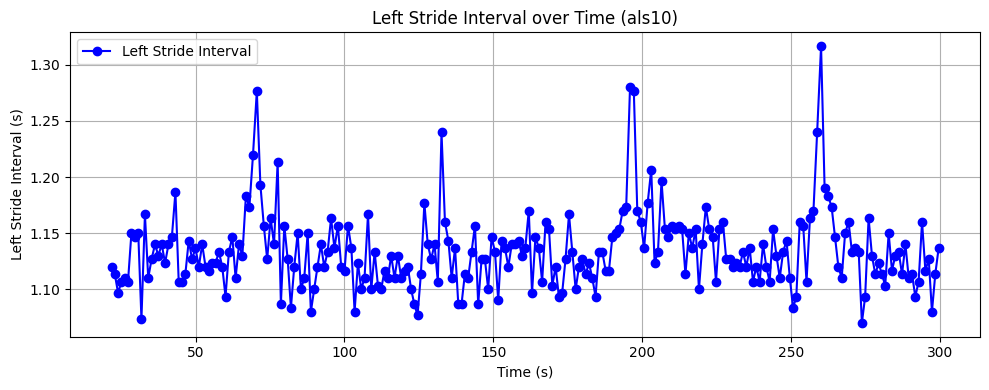

In [17]:
import matplotlib.pyplot as plt

# Choose a subject ID from data_dict
subject_id = list(data_dict.keys())[1]  # or 'park01', 'hunt03', etc.

# Extract time series data
ts_data = data_dict[subject_id]["time_series"]

# Plot Left Stride Interval vs Time
plt.figure(figsize=(10, 4))
plt.plot(ts_data["Time"], ts_data["L_Stride"], marker='o', linestyle='-', color='blue', label='Left Stride Interval')
plt.xlabel("Time (s)")
plt.ylabel("Left Stride Interval (s)")
plt.title(f"Left Stride Interval over Time ({subject_id})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
